# Cinemática Direta

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Classes


### Elo

A classe elo representação o elo físico do rôbo. Cada elo é descrito por meio dos parâmetros da notação de Denavit-Hartenberg (DH)

* theta: Ângulo de rotação em torno do eixo z (graus)
* d: Distância ao longo do eixo z (cm)
* a: Comprimento do elo (cm)
* alpha: Ângulo de rotação em torno do eixo x comum (graus)
* phase: Fase do ângulo de rotação em torno do eixo z (graus)



In [2]:
class Elo:
  # Construtor da classe Elo
  def __init__(self,theta,d,a,alpha,phase):
    self.theta = theta
    self.d = d
    self.a = a
    self.alpha = alpha
    self.phase = phase

### Robo


O parâmetro variável da junta rotativa/torcional deve ser um string. Os Elos devem serem informado usando uma lista, como no exemplo abaixo:

```
  Elos = [['theta_1',d,a,alpha,phase],
          ['theta_2',d,a,alpha,phase]]
```

Exemplo:

```
  Elos = [['theta_1',10,0,90,0],
        ['theta_2',0,18,180,0]]
  
  robo = Robo('NomeRobo',Elos)


  

In [3]:
from numpy import array
from numpy import radians as npradians
from sympy import sin, cos, Matrix,symbols, simplify, nsimplify, eye,Symbol
from math import radians

class Robo:
  # Construtor da classe
  def __init__(self,nameBot,elos):
    self.nameBot = nameBot
    self.series = self.__series_link(elos)
    self.matrixForwardKinematics = self.__homogeneous_transformations()
    self.joinName = self.__join_names()
    self.__simplifForwardKinematics = None

  # Método privado para criar a cadeia cinemática de elos. Obs: tenho que deixar mais generalista. Apenas juntas rotativas estão valendo
  def __series_link(self,elos):
    series = []
    for elemento in elos:
      series.append(Elo(symbols(elemento[0], real = True),elemento[1],elemento[2],elemento[3],elemento[4]))
    return series

  # Método privado para criar uma matriz de transformação homogênea de DH genérica
  def __matrix_homogeneous_transformations(self,theta, d, a, alpha):
    alpha = radians(alpha)
    r = 5
    # Matriz TH para a notação denavit-hartenberg
    matrix = Matrix([
            [cos(theta), -sin(theta) * cos(alpha).round(r), sin(theta) * sin(alpha).round(r), a * cos(theta)],
            [sin(theta), cos(theta) * cos(alpha).round(r), -cos(theta) * sin(alpha).round(r), a * sin(theta)],
            [0, sin(alpha).round(r), cos(alpha).round(r), d],
            [0, 0, 0, 1]
        ])
    return matrix

  # Método privado que define a matriz de tranformação total do manipulador
  def __homogeneous_transformations(self):
    # Inicializa a matriz transformação homogênea
    matrix_TH = eye(4)
    # Percorre os elos
    for elo in self.series:
      matrix = self.__matrix_homogeneous_transformations(elo.theta+radians(elo.phase),elo.d,elo.a,elo.alpha)
      matrix_TH = matrix_TH @ matrix
    return matrix_TH

  # Método público que exibe e seta a matriz de transformação no formato reduzida
  def show_matrix_ForwardKinematics(self):
    # Simplifica uma unica vez e exibe nas proximas vezes a matriz homogenia
    if self.__simplifForwardKinematics is None:
      self.__simplifForwardKinematics = simplify(nsimplify(self.matrixForwardKinematics))
      self.matrixForwardKinematics = self.__simplifForwardKinematics
      return self.__simplifForwardKinematics
    else:
      return self.__simplifForwardKinematics

  # Método privado que coleta as variáveis das juntas
  def __join_names(self):
    # Declara a variável como um conjunto para que só exista apenas uma varivel
    joinName = []
    # Percorre a cadeia cinemática de elos
    for elo in self.series:
      # Analisa cada atributo da classe elo
      for att,val in elo.__dict__.items():
        # Amazena o nome da variavel do atributo que é uma variável simbólica
        if isinstance(val, Symbol):
          joinName.append(val)
    return joinName

  # Método que retorna a matriz de transform
  def frame_effector(self,pose):
    joinName = self.joinName
    pose = npradians(pose)
    #if len(joinName) == len(pose):
    data = dict(zip(joinName,pose))
    return self.matrixForwardKinematics.evalf(subs=data).tolist()
    #else:
      #print("Número de valores é diferente das variáveis")

## Mapeamento da Cinemática Direta

A base de dados é criada com base no mapeadomento da cinemática direta. Isso ocorre definindo a modelagem direta do manipulador. Ao passo que necessário criar o espaço de possibilidade de atuação das variáveis das juntas. Assim, cada conjunto de junta entra na modelagem direta que retorna a matriz de tranformação homogênea do sistema de coordenadas do efetuador, aqui nomeado espaço operacional. Através dessas desses dois espaços é possível mapear a cinemática direta do manipulador. 

In [4]:
# Define os parâmetros DH para cada elo
Elos = [['theta_1',10,0,90,0],
        ['theta_2',0,18,180,0],
        ['theta_3',0,18,-180,0],

        ['theta_4',0,0,90,90],
        ['theta_5',18,0,0,0]]

# Cria o robo por meio dos parâmetros
robo = Robo('Robotest',Elos)

In [5]:
robo.show_matrix_ForwardKinematics()

Matrix([
[sin(theta_1)*sin(theta_5) + cos(theta_1)*cos(theta_5)*cos(theta_2 - theta_3 + theta_4 + 15707963267949/10000000000000),  sin(theta_1)*cos(theta_5) - sin(theta_5)*cos(theta_1)*cos(theta_2 - theta_3 + theta_4 + 15707963267949/10000000000000), sin(theta_2 - theta_3 + theta_4 + 15707963267949/10000000000000)*cos(theta_1), 18*(sin(theta_2 - theta_3 + theta_4 + 15707963267949/10000000000000) + cos(theta_2) + cos(theta_2 - theta_3))*cos(theta_1)],
[sin(theta_1)*cos(theta_5)*cos(theta_2 - theta_3 + theta_4 + 15707963267949/10000000000000) - sin(theta_5)*cos(theta_1), -sin(theta_1)*sin(theta_5)*cos(theta_2 - theta_3 + theta_4 + 15707963267949/10000000000000) - cos(theta_1)*cos(theta_5), sin(theta_1)*sin(theta_2 - theta_3 + theta_4 + 15707963267949/10000000000000), 18*(sin(theta_2 - theta_3 + theta_4 + 15707963267949/10000000000000) + cos(theta_2) + cos(theta_2 - theta_3))*sin(theta_1)],
[                                         sin(theta_2 - theta_3 + theta_4 + 15707963267949/10000000

### Espaço das Juntas

In [6]:
# Limites físicos das juntas em graus
junta1 = [0, 120]
junta2 = [0, 120]
junta3 = [0, 120]
junta4 = [0, 120]
junta5 = [0, 0]

In [7]:
# passo de amostragem
step_1 = 5
step_2 = junta2[1]//10
step_3 = junta3[1]//10
step_4 = junta4[1]//10
step_5 = 1

In [8]:
# Criando uma lista para armazenar os dados
data_join = []

# Criando a matriz com todas as combinações de ângulos
for angulo_1 in range(junta1[0], junta1[1] + 1, step_1):
    for angulo_2 in range(junta2[0], junta2[1] + 1, step_2):
        for angulo_3 in range(junta3[0], junta3[1] + 1, step_3):
            for angulo_4 in range(junta4[0], junta4[1] + 1, step_4):
                data_join.append([angulo_1, angulo_2, angulo_3, angulo_4, junta5[0]])

In [9]:
df_join = pd.DataFrame(data_join, columns=robo.joinName)
df_join

,theta_1,theta_2,theta_3,theta_4,theta_5
0,0,0,0,0,0
1,0,0,0,12,0
2,0,0,0,24,0
3,0,0,0,36,0
4,0,0,0,48,0
...,...,...,...,...,...
33270,120,120,120,72,0
33271,120,120,120,84,0
33272,120,120,120,96,0
33273,120,120,120,108,0


### Espaço Operacional

In [10]:
# Cria uma matriz de 12 colunas vazia
data_operacional = np.empty((0, 12))

# Percorre a base de dados substituindo na matriz de transformação
for pose in data_join:
  # Cria um vetor da matriz de tranformação excluindo a ultima linha
  vetor = np.array(robo.frame_effector(pose)[:3]).reshape(-1)
  # Salva o vetor na matriz do espaço operacional
  data_operacional = np.vstack([data_operacional,vetor])

In [11]:
# Cria um dataframe da matriz do espaço operacional
df_pose = pd.DataFrame(data_operacional,columns=['R_11','R_12','R_13','p_x','R_21','R_22','R_23','p_y','R_31','R_32','R_33','p_z'])
df_pose

,R_11,R_12,R_13,p_x,R_21,R_22,R_23,p_y,R_31,R_32,R_33,p_z
0,-3.38076867830836e-15,0,1.00000000000000,54.0000000000000,0,-1.00000000000000,0,0,1.00000000000000,0,3.38076867830836e-15,10.0000000000001
1,-0.207911690817763,0,0.978147600733805,53.6066568132085,0,-1.00000000000000,0,0,0.978147600733805,0,0.207911690817763,13.7424104347197
2,-0.406736643075803,0,0.913545457642600,52.4438182375668,0,-1.00000000000000,0,0,0.913545457642600,0,0.406736643075803,17.3212595753645
3,-0.587785252292476,0,0.809016994374945,50.5623058987490,0,-1.00000000000000,0,0,0.809016994374945,0,0.587785252292476,20.5801345412646
4,-0.743144825477397,0,0.669130606358856,48.0443509144594,0,-1.00000000000000,0,0,0.669130606358856,0,0.743144825477397,23.3766068585931
...,...,...,...,...,...,...,...,...,...,...,...,...
33270,0.475528258147577,0.866025403784439,-0.154508497187472,-7.28115294937450,-0.823639103546333,0.500000000000000,0.267616567329815,12.6113268459966,0.309016994374944,0,0.951056516295155,42.7074745614327
33271,0.497260947684137,0.866025403784439,-0.0522642316338250,-5.44075616940885,-0.861281226008775,0.500000000000000,0.0905243046083336,9.42366611700996,0.104528463267650,0,0.994521895368274,43.4898513847488
33272,0.497260947684136,0.866025403784439,0.0522642316338284,-3.55924383059109,-0.861281226008774,0.500000000000000,-0.0905243046083395,6.16479115110984,-0.104528463267657,0,0.994521895368273,43.4898513847488
33273,0.475528258147576,0.866025403784439,0.154508497187475,-1.71884705062545,-0.823639103546331,0.500000000000000,-0.267616567329820,2.97713042212319,-0.309016994374951,0,0.951056516295153,42.7074745614326


In [12]:
# Concatena as matrix do espaço operacional com a do espaço da juntas
df_dataset = pd.concat([df_join, df_pose], axis=1)
df_dataset

,theta_1,theta_2,theta_3,theta_4,theta_5,R_11,R_12,R_13,p_x,R_21,R_22,R_23,p_y,R_31,R_32,R_33,p_z
0,0,0,0,0,0,-3.38076867830836e-15,0,1.00000000000000,54.0000000000000,0,-1.00000000000000,0,0,1.00000000000000,0,3.38076867830836e-15,10.0000000000001
1,0,0,0,12,0,-0.207911690817763,0,0.978147600733805,53.6066568132085,0,-1.00000000000000,0,0,0.978147600733805,0,0.207911690817763,13.7424104347197
2,0,0,0,24,0,-0.406736643075803,0,0.913545457642600,52.4438182375668,0,-1.00000000000000,0,0,0.913545457642600,0,0.406736643075803,17.3212595753645
3,0,0,0,36,0,-0.587785252292476,0,0.809016994374945,50.5623058987490,0,-1.00000000000000,0,0,0.809016994374945,0,0.587785252292476,20.5801345412646
4,0,0,0,48,0,-0.743144825477397,0,0.669130606358856,48.0443509144594,0,-1.00000000000000,0,0,0.669130606358856,0,0.743144825477397,23.3766068585931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33270,120,120,120,72,0,0.475528258147577,0.866025403784439,-0.154508497187472,-7.28115294937450,-0.823639103546333,0.500000000000000,0.267616567329815,12.6113268459966,0.309016994374944,0,0.951056516295155,42.7074745614327
33271,120,120,120,84,0,0.497260947684137,0.866025403784439,-0.0522642316338250,-5.44075616940885,-0.861281226008775,0.500000000000000,0.0905243046083336,9.42366611700996,0.104528463267650,0,0.994521895368274,43.4898513847488
33272,120,120,120,96,0,0.497260947684136,0.866025403784439,0.0522642316338284,-3.55924383059109,-0.861281226008774,0.500000000000000,-0.0905243046083395,6.16479115110984,-0.104528463267657,0,0.994521895368273,43.4898513847488
33273,120,120,120,108,0,0.475528258147576,0.866025403784439,0.154508497187475,-1.71884705062545,-0.823639103546331,0.500000000000000,-0.267616567329820,2.97713042212319,-0.309016994374951,0,0.951056516295153,42.7074745614326


## Pré-processamento da Base de Dados

Nem todos os pontos criados no mapeamento são de fato relevantes durante o aprendizado de máquina. A casos em que as amostras se apresentam impossíveis para o problema. E também existe situações em que as amostras possuiem várias pontos do espaço da juntas como solução da descrição do espaço das juntas. Para essas amostras, chamaremos de redundâncias. Elas são prejudiciais no treinamento e aprendizado do modelo de máquina.

### Figuras

In [ ]:
def plot2D(df_dataset,labels):
  # Cria uma figura de tamanho n por n
  figura = plt.figure(figsize=(10, 10))

  num_amostra, num_feat = df_dataset.shape

  # Configura o suubplot para gráficos 3D
  grafico = figura.add_subplot(111)

  # Adiciona ao subplot um gráfico de dispersão
  grafico.scatter(df_dataset[labels[0]],df_dataset[labels[1]], s=1, c=np.random.rand(num_amostra), alpha=1, cmap="inferno")

  minimos = df_dataset.min()
  maximos = df_dataset.max()

  grafico.set_xlim(minimos[labels[0]], maximos[labels[0]])
  grafico.set_ylim(minimos[labels[1]], maximos[labels[1]])

  grafico.set_xlabel(labels[0])
  grafico.set_ylabel(labels[1])

  plt.show()

def plot3D(df_dataset,labels):
  # Cria uma figura de tamanho n por n
  figura = plt.figure(figsize=(10, 10))

  num_amostra, num_feat = df_dataset.shape

  # Configura o suubplot para gráficos 3D
  grafico = figura.add_subplot(111, projection='3d')

  # Adiciona ao subplot um gráfico de dispersão
  grafico.scatter(df_dataset[labels[0]],df_dataset[labels[1]],df_dataset[labels[2]], s=1, c=np.random.rand(num_amostra), alpha=1, cmap="inferno")

  minimos = df_dataset.min()
  maximos = df_dataset.max()

  grafico.set_xlim(minimos[labels[0]], maximos[labels[0]])
  grafico.set_ylim(minimos[labels[1]], maximos[labels[1]])
  grafico.set_zlim(minimos[labels[2]], maximos[labels[2]])

  grafico.set_xlabel(labels[0])
  grafico.set_ylabel(labels[1])
  grafico.set_zlabel(labels[2])
  plt.show()

### Limitações Físicas

Nesta etapa do pré processamento é excluido algumas amostras que são jungadas como impossíveis para o manipulador.
- Altura negativa do efetuador
- Altura negativa de cada elo

#### Altura negativa

Vemos desconsiderar as amostras que apresentam pontos no semi-eixo **Z** negativo.

In [ ]:
# Armazena os índices negativos
idx_negativo = df_dataset[df_dataset['p_z']<0].index
len(idx_negativo)

4675

In [ ]:
df_dataset = df_dataset.drop(idx_negativo)
print("Tamanho atual da base de dados:")
df_dataset.shape

Tamanho atual da base de dados:


(28600, 17)

#### Elos negativos

Nesta etapa, é necessário cria alguns robôs parciais elo por elo, para analisar se seu frame bate no chão.

Pela caracteristica física do manipulador e do eixo de rotação de seus atuadores, devemos analisar o Elo 3. Para os demais, é observado que não é possível se alcançar as limitações. Com excessão do elo do efetuar, mas esse já é restringido no filtro acima.

In [ ]:
# Define os parâmetros DH para cada elo
Elos = [['theta_1',10,0,90,0],
        ['theta_2',0,18,180,0],
        ['theta_3',0,18,-180,0]
        ]

# Cria o robo por meio dos parâmetros
robo = Robo('Robo_3',Elos)

In [ ]:
df_join3 = df_dataset[['theta_1','theta_2','theta_3']]
df_join3

,theta_1,theta_2,theta_3
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
33270,120,120,120
33271,120,120,120
33272,120,120,120
33273,120,120,120


In [ ]:
num_z = 0
# Percorre toda o dataset
for indx,angle in df_join3.iterrows():
  # Se altura alcançada em Z for negativa
  if (robo.frame_effector(angle)[2][3]) < 0:
      # Apaga a linha do dataset
      df_dataset = df_dataset.drop(indx)
      num_z+=1

In [ ]:
print("Dimensão da nova base {}".format(df_dataset.shape))
print("Número de amostras apagadas{}".format(num_z))

Dimensão da nova base (27625, 17)
Número de amostras apagadas975


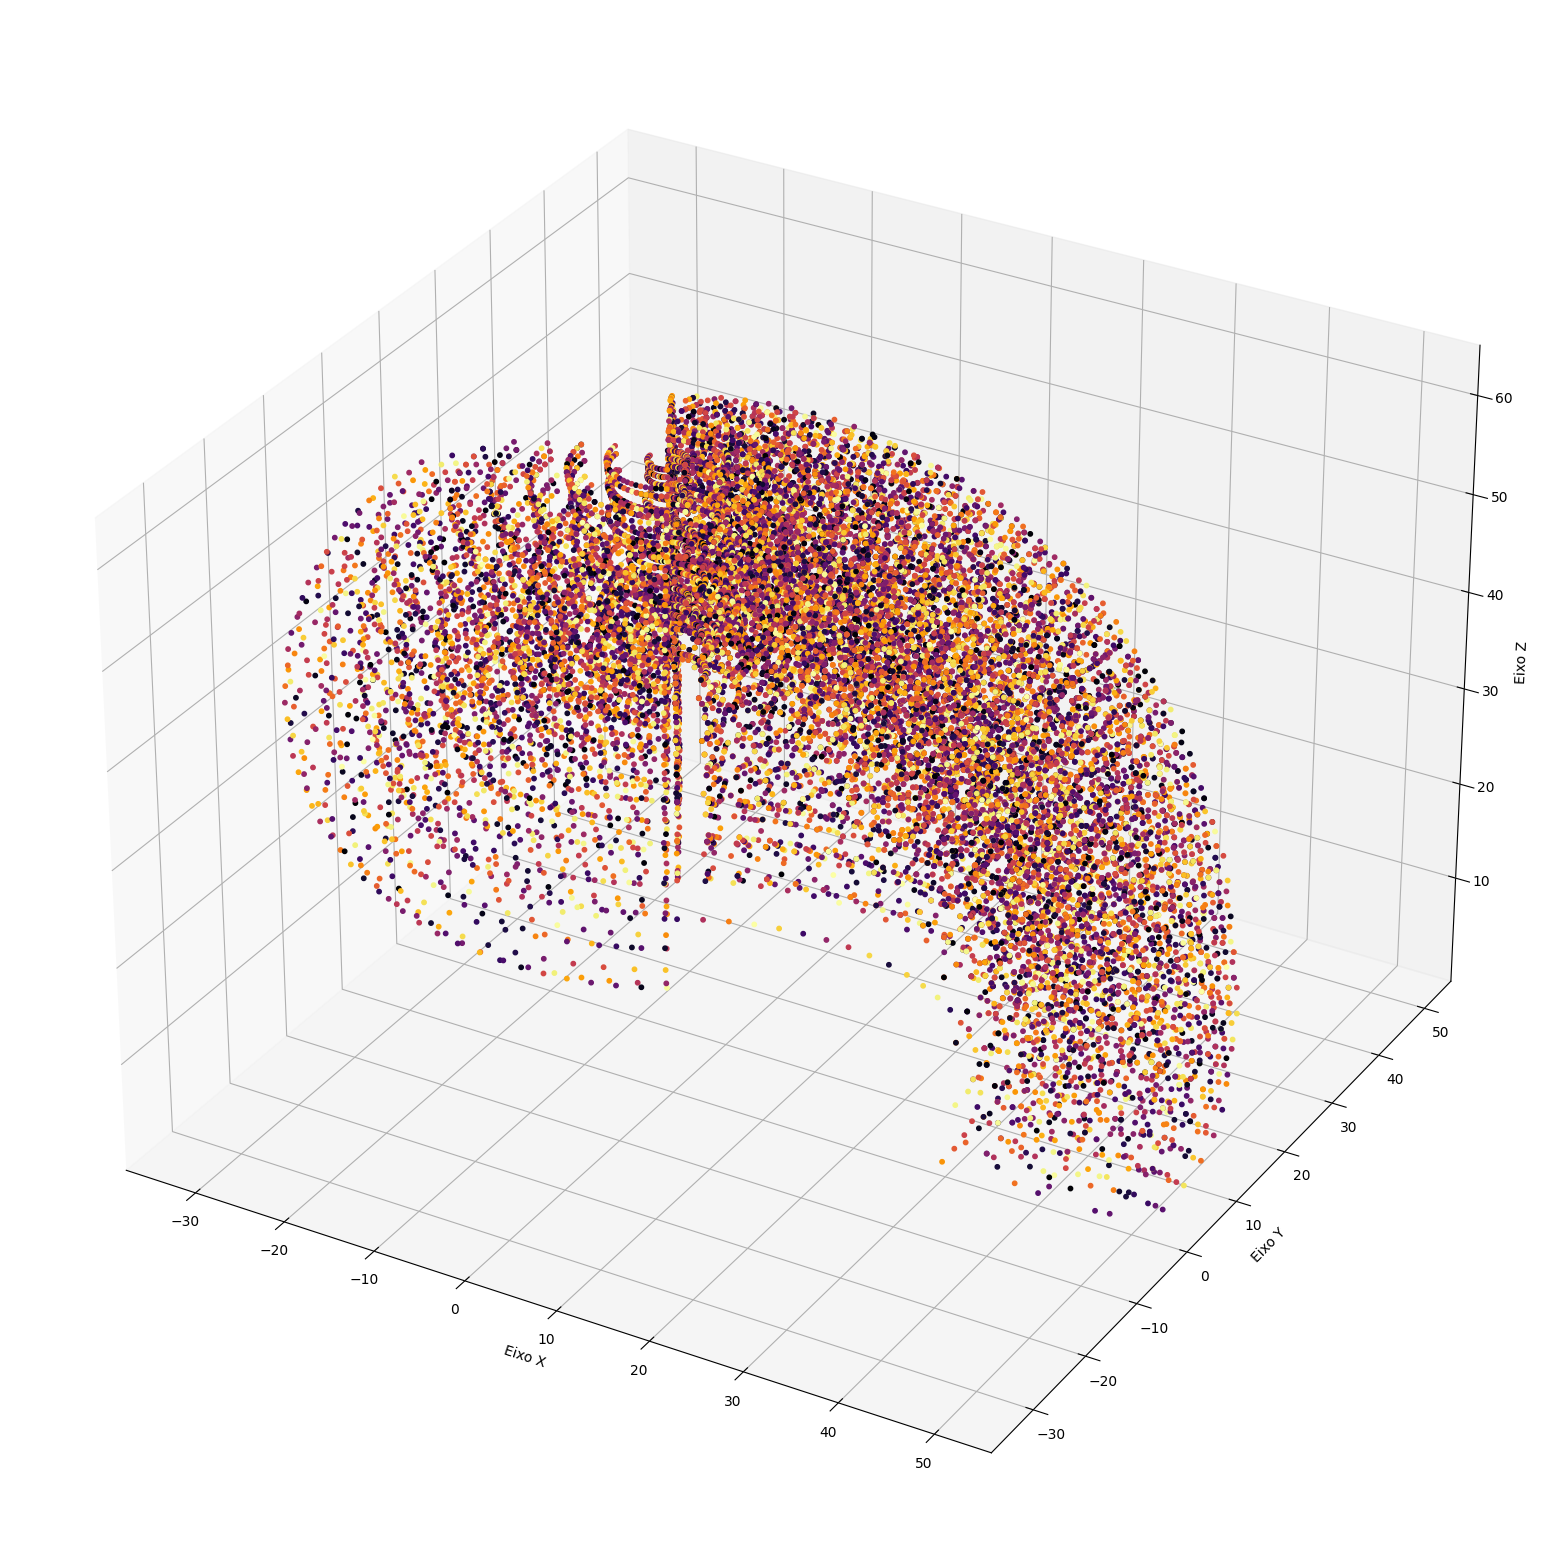

In [ ]:
plot3D(df_dataset)

### Redundâncias

In [ ]:
df_dataset_1 = df_dataset.copy()

In [ ]:
# Função que retorna os vizinhos próximos em torno de uma raio
def neighbors(amostra, posicoes, raio):
    ## Colocar restrinção se tam(amostra) = tam(posições)
    if len(amostra) == posicoes.shape[1]:
      # Converte a amostra em numpy
      amostra = np.array(amostra)

      # Calcula a diferença entre a amostra e a base de dados
      diferenca = (posicoes - amostra) ** 2

      # Calcula a distância euclidiana e armazena em um dataframe
      df_distancia = pd.DataFrame(diferenca.sum(axis=1),columns=['Distâncias']).map(np.sqrt)

      # Retornar é menor ou igual ao raio definido
      return df_distancia[(df_distancia<=raio).all(axis=1)]
    else:
        print("Dimensão errada dos atributos")
        return None

def redundancias(vizinhos,df_dataset):
  # Retorna do dataset os vizinhos próximos
  dataset_join = df_dataset.loc[vizinhos.index]

  if not dataset_join.empty and not vizinhos.empty :
    # Percorre as colunas das juntas dos vizinhos (redundâncias) próximos excluindo (filtrados) os dados
    for col_join in dataset_join.columns:
      # theta_3 pega os indices com os menores angulos
      if col_join == 'theta_3':
        indices = dataset_join.index[dataset_join[col_join] == dataset_join[col_join].min()]
      # C.C pega os indices com os maiores angulos
      else:
        indices = dataset_join.index[dataset_join[col_join] == dataset_join[col_join].max()]
      # caso existir apenas uma amostra
      cond1 = indices.shape[0] == 1
      if cond1:
        # Retorna os indices a serem excluidos
        return  vizinhos.index.difference(indices)
        break
      elif not cond1 and col_join == 'theta_5': # caso persistir a redundância
        # Pega o indice da maior distância dos últimos vizinhos
        indices = vizinhos.loc[indices].idxmax()
        return  vizinhos.index.difference(indices)
        break
      else: # Caso ainda exista muita redundância
        # Remove da analise as amostras não pertinentes
        dataset_join.drop(dataset_join.index.difference(indices),inplace=True)

    else:
      return list([])

In [ ]:
df_dataset = df_dataset_1.copy()

In [ ]:
redund_ind = set()
for indice in df_dataset.index:
  # Cria um dataset da amostra em seguente
  df = df_dataset.loc[indice:]
  amostra = df_dataset.loc[indice]
  # Pega os vizinhos
  vizinhos = neighbors(amostra[['p_x','p_y','p_z']],df[['p_x','p_y','p_z']],0.5)
  redund_ind.update(redundancias(vizinhos,df[['theta_2','theta_3','theta_4','theta_5']]))

In [ ]:
# 0.5
df_dataset = df_dataset.drop(redund_ind)
print(df_dataset.shape)
plot3D(df_dataset)